In [3]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np


In [4]:
model = VGG19(weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


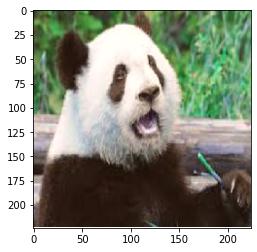

In [5]:
import matplotlib.pyplot as plt
img_path = '1.PNG'
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
plt.imshow(np.squeeze(x)/256.0+0.5)
plt.show()

In [6]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=1)[0])

C:\Users\lu936\miniconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: [('n02510455', 'giant_panda', 0.99936336)]


## Test if VGG19 is actually working

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


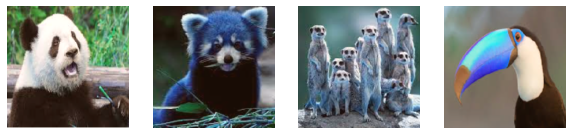

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
xs = []
for i in range(1,5):
    img = image.load_img(f'{i}.PNG', target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    axs[i-1].imshow(np.squeeze(x)/256.0+0.5)
    axs[i-1].axis('off')
    xs.append(x)
plt.show()

In [8]:
for x in xs:
    print("Predicted:",  decode_predictions(model.predict(x), top=1)[0])

Predicted: [('n02510455', 'giant_panda', 0.99936336)]
Predicted: [('n02509815', 'lesser_panda', 0.99994457)]
Predicted: [('n02138441', 'meerkat', 0.92550254)]
Predicted: [('n01843383', 'toucan', 0.9999945)]


## Part2

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [9]:
from keras import backend as K

# Selecting a layer and channel to visualize
layer_name = 'block5_conv2'
filter_index = 185
 
# Isolate the output and loss for the given chanel
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, model.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L2 norm (square root
# of the mean of the square of values in the tensor). We add a small epsilon term to the L2 norm
# to avoid division by zero.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([model.input], [loss, grads])

# To quickly test the interface:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [12]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    # add this operation to the computation graph
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    # get back the computation graph operations to run
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        
    img = input_img_data[0]
    return deprocess_image(img)

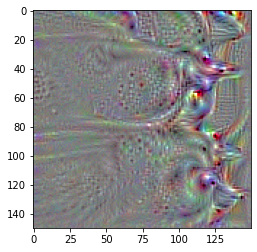

In [16]:
plt.imshow(generate_pattern(layer_name, filter_index))
plt.show()

## Part 3